In [1]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import pickle
import tensorflow as tf
import numpy as np
from keras.layers import LSTM, Activation, Dense, Dropout, Dot, Permute
from keras.layers import Lambda, Input, Embedding, multiply, Softmax, LeakyReLU
from keras.activations import tanh
from keras.models import Model
from keras.optimizers import RMSprop
from mcc_funcs import *

I0901 20:37:31.397851 140509067020096 file_utils.py:41] PyTorch version 1.5.0 available.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist

In [2]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
model = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")

I0901 20:37:36.266903 140509067020096 configuration_utils.py:283] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/allenai/scibert_scivocab_uncased/config.json from cache at /home/sandora/.cache/torch/transformers/199e28e62d2210c23d63625bd9eecc20cf72a156b29e2a540d4933af4f50bda1.4b6b9f5d813f7395e7ea533039e02deb1723d8fd9d8ba655391a01a69ad6223d
I0901 20:37:36.268231 140509067020096 configuration_utils.py:319] Model config BertConfig {
  "_num_labels": 2,
  "architectures": null,
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
   

In [3]:
with open('data/title2list.pkl','rb') as f:
    title2list = pickle.load(f)
    
with open('data/title2xml.pkl','rb') as f:
    title2xml = pickle.load(f)
    
with open('label_map.pkl','rb') as f:
    label_map = pickle.load(f)

concepts = list(set.union(*list(label_map.values())))

dfsent = pd.read_csv('sentence_labels2.tsv',sep='\t')
dfsent = dfsent.drop_duplicates()

In [4]:
%%time
def encode(text_list,k=1):
    inputs = tokenizer.batch_encode_plus(
        text_list,
        add_special_tokens=True,
        pad_to_max_length=True,
        return_tensors="pt",
    )
    with torch.no_grad():
        outputs = model(inputs["input_ids"])
    return np.array(outputs[k])

concdescs = [' '.join(title2list[c])[:2000] for c in concepts]


V = encode(concdescs)

CPU times: user 4min 10s, sys: 3min 23s, total: 7min 33s
Wall time: 31.2 s


In [11]:
%%time
from sklearn.model_selection import train_test_split

X = encode(dfsent['sentence'],0)

y = np.array([[int(c in eval(D['titles'])) for c in concepts]
          for _,D in dfsent.iterrows()])

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                    test_size=0.1, random_state=1066)

CPU times: user 4min 37s, sys: 2min 17s, total: 6min 55s
Wall time: 31.4 s


In [58]:
num_concepts = len(concepts)

in_shape = X.shape[1:]
embed_size = X.shape[-1]

def LWA(V,vb=True):
    D = Input(name='inputs',shape=in_shape)
    D2 = Dense(embed_size, activation='tanh')(D)
    A = Dense(num_concepts,trainable=False,use_bias=False,weights=[V.T])(D2)
    A = Softmax()(A)
    C = Dot(axes=(1,1))([A,D])
    E = Dense(embed_size)(C)
    E = LeakyReLU()(E)
    Y = Dense(num_concepts,trainable=False,use_bias=False,weights=[V.T])(E)
    Y = Lambda(lambda x:tf.linalg.diag_part(x))(Y)
    Y = Activation('sigmoid')(Y)
    if vb:
        print('D',D.shape)
        print('D2',D2.shape)
        print('V',V.shape)
        print('A',A.shape)
        print('C',C.shape)
        print('E',E.shape)
        print('Y',Y.shape)

    model = Model(inputs=D,outputs=Y)
    return model

model_lwa = LWA(V)
model_lwa.summary()

from keras import backend as K
def f1(yp,yt):
    TP = K.sum(K.round(K.clip(yp*yt, 0, 1)))
    FP = K.sum(K.round(K.clip(yp*(1-yt), 0, 1)))
    FN = K.sum(K.round(K.clip((1-yp)*yt, 0, 1)))
    F1 = 2*TP/(2*TP+FP+FN+10**-8)
    return F1
    
model_lwa.compile(loss='categorical_crossentropy',optimizer=RMSprop(),
              metrics=[f1])

D (?, 67, 768)
D2 (?, 67, 768)
V (121, 768)
A (?, 67, 121)
C (?, 121, 768)
E (?, 121, 768)
Y (?, 121)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 67, 768)      0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 67, 768)      590592      inputs[0][0]                     
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 67, 121)      92928       dense_9[0][0]                    
__________________________________________________________________________________________________
softmax_3 (Softmax)             (None, 67, 121)      0           dense_10[0][0]                   
_______

In [59]:
model_lwa.fit(X_train,y_train,batch_size=256,epochs=40,validation_split=.2)

Train on 833 samples, validate on 209 samples
Epoch 1/40
833/833 [==============================] - 2s 3ms/step - loss: 11.8729 - f1: 0.0381 - val_loss: 10.4803 - val_f1: 0.0537
Epoch 2/40
833/833 [==============================] - 2s 2ms/step - loss: 10.2431 - f1: 0.0558 - val_loss: 10.4202 - val_f1: 0.0541
Epoch 3/40
833/833 [==============================] - 2s 2ms/step - loss: 10.1815 - f1: 0.0566 - val_loss: 10.3863 - val_f1: 0.0538
Epoch 4/40
833/833 [==============================] - 2s 2ms/step - loss: 10.1499 - f1: 0.0566 - val_loss: 10.3613 - val_f1: 0.0561
Epoch 5/40
833/833 [==============================] - 2s 2ms/step - loss: 10.1274 - f1: 0.0556 - val_loss: 10.3250 - val_f1: 0.0481
Epoch 6/40
833/833 [==============================] - 2s 2ms/step - loss: 10.0956 - f1: 0.0509 - val_loss: 10.3057 - val_f1: 0.0507
Epoch 7/40
833/833 [==============================] - 2s 2ms/step - loss: 10.0605 - f1: 0.0521 - val_loss: 10.2827 - val_f1: 0.0599
Epoch 8/40
833/833 [==========

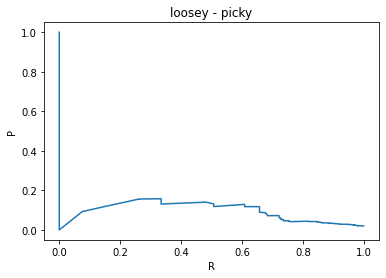

auc:  0.095
f1/2:  0.176


/home/sandora/notebooks/ctha-statdx-analysis/mcc_funcs.py:193: RuntimeWarning: invalid value encountered in true_divide
  f = (1+b**2)*p*r/(b**2*p+r)


In [60]:
y_pred = model_lwa.predict(X_test)

ps,rs,ts=precision_recall_curve(y_test.reshape(-1),y_pred.reshape(-1))
plt.plot(rs,ps)
plt.xlabel('R')
plt.ylabel('P')
plt.title('loosey - picky')
plt.show()
print('auc: ',round(auc(rs,ps),3))
fhalf = Fb(1/2,ps,rs)
fhalf = fhalf[np.argwhere(fhalf>0)]
print('f1/2: ',round(np.max(fhalf),3))

In [30]:
X.shape

(1158, 67, 768)

In [36]:
predies = model_lwa.predict(X)
predies[0]

array([0.24865723, 0.136237  , 0.00549656, 0.01553103, 0.        ,
       0.05950803, 0.24245635, 0.02111211, 0.07539424, 0.07772562,
       0.14104536, 0.05696604, 0.1265822 , 0.01985392, 0.04228339,
       0.1162174 , 0.0547595 , 0.01566693, 0.25100952, 0.06725475,
       0.06356865, 0.05814874, 0.16306055, 0.11725584, 0.04632452,
       0.00700718, 0.14360732, 0.13007128, 0.08306849, 0.01098138,
       0.01987693, 0.09859949, 0.05335024, 0.15128171, 0.01237404,
       0.27738565, 0.01655963, 0.2514553 , 0.16276315, 0.01492143,
       0.02834383, 0.12334195, 0.01972112, 0.05764866, 0.02728125,
       0.05950794, 0.07329962, 0.042088  , 0.03394338, 0.02662343,
       0.01987919, 0.13415033, 0.03608128, 0.05926079, 0.00860107,
       0.14579582, 0.16257718, 0.16547662, 0.        , 0.15832281,
       0.03985026, 0.05067232, 0.06695673, 0.02678391, 0.06907675,
       0.10749558, 0.07155904, 0.0243127 , 0.09233838, 0.21224615,
       0.05868194, 0.13600436, 0.13156265, 0.12195614, 0.11820

In [51]:
mimic_files = list(set(dfsent.mimic_file))

In [54]:

def file2df(mimi):
    scorelist = list(zip(concepts,
          np.max(predies[np.where(
              dfsent.mimic_file==mimi)],axis=0)))
    df_scores = pd.DataFrame(scorelist,columns=['title','score'])
    df_scores['mimic_file'] = mimi
    return df_scores


df_all = pd.DataFrame()
for m in mimic_files:
    df = file2df(m)
    df_all = df_all.append(df)

In [57]:
df_all.to_csv('labels_lwa.tsv',sep='\t',index=False)

In [49]:
import os,sys
HOME = os.path.expanduser('~')
sys.path.insert(0,'%s/notebooks/gitlab/elsnlp' % HOME)
sys.path.insert(0,'%s/notebooks/symptom_checker' % HOME)
from elsnlp import fpe, cm2, hgraph, memsource, etm, qpe
from cano import *
get_hat_imuis(dfsent['0'].iloc[3])

[]

In [48]:
import requests,itertools
def hat_annotate(text):
    url = 'http://ec2-3-16-19-29.us-east-2.compute.amazonaws.com:5027/annotate'
    headers = {'txt':text,
               'mode':2,
               'emmet':True,
               'umls':True,
               'cotype':2,
               'cased':True,
               'ocr':False}

    response = requests.get(url,headers)
    return response.json()

def get_hat_imuis(text):
    try:
        hat_json = hat_annotate(text)
        dicts = [d for d in list(itertools.chain(*hat_json)) if type(d)==dict]
        imuis = [[D[k][8] for k in D] for D in dicts]
        imuis = list(itertools.chain(*imuis))
        imuis = [int(i) for i in imuis if i!=None]
    except:
            imuis=[]
    return imuis

In [132]:
concimuis = [cm2_imuis(' '.join(title2list[c])) for c in concepts]

In [133]:
dfsent['cm2'] = [cm2_imuis(i) for i in dfsent.sentence]

In [134]:
all_imuis = list(set(itertools.chain(*concimuis))|\
     set(itertools.chain(*[d for d in dfsent.cm2 if d!=None])))

In [135]:
V_imui = np.array([[int(i in c) for i in all_imuis] for c in concimuis])

In [129]:
V_imui.shape

(121, 3061)

In [ ]:
dfsent.cm2 = [i if i!=None else [] for i in dfsent.cm2]

In [10]:

X = np.array([[int(i in c) for i in all_imuis] for c in dfsent.cm2])
X = np.expand_dims(X,axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                    test_size=0.1, random_state=1066)

AttributeError: 'DataFrame' object has no attribute 'cm2'

In [228]:
num_concepts = len(concepts)

in_shape = X.shape[1:]
embed_size = X.shape[-1]

def LWA(V,vb=True):
    D = Input(name='inputs',shape=in_shape)
    D2 = Dense(embed_size, activation='tanh')(D)
    A = Dense(num_concepts,trainable=False,use_bias=False,weights=[V.T])(D2)
    A = Softmax()(A)
    C = Dot(axes=(1,1))([A,D])
    E = Dense(embed_size)(C)
    E = LeakyReLU()(E)
    Y = Dense(num_concepts,trainable=False,use_bias=False,weights=[V.T])(E)
    Y = Lambda(lambda x:tf.linalg.diag_part(x))(Y)
    Y = Activation('sigmoid')(Y)
    if vb:
        print('D',D.shape)
        print('D2',D2.shape)
        print('V',V.shape)
        print('A',A.shape)
        print('C',C.shape)
        print('E',E.shape)
        print('Y',Y.shape)

    model = Model(inputs=D,outputs=Y)
    return model

model_lwa = LWA(V_imui)
model_lwa.summary()


def f1(yp,yt):
    TP = np.sum(yp*yt)
    FP = np.sum(yp*(1-yt))
    FN = np.sum((1-yp)*yt)
    F1 = 2*TP/(2*TP+FP+FN+10**-8)
    return F1
    
model_lwa.compile(loss='categorical_crossentropy',optimizer='adam',
              metrics=[f1])

D (?, 1, 3061)
D2 (?, 1, 3061)
V (121, 3061)
A (?, 1, 121)
C (?, 121, 3061)
E (?, 121, 3061)
Y (?, 121)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 1, 3061)      0                                            
__________________________________________________________________________________________________
dense_53 (Dense)                (None, 1, 3061)      9372782     inputs[0][0]                     
__________________________________________________________________________________________________
dense_54 (Dense)                (None, 1, 121)       370381      dense_53[0][0]                   
__________________________________________________________________________________________________
softmax_13 (Softmax)            (None, 1, 121)       0           dense_54[0][0]                   
_____

In [229]:
model_lwa.fit(X_train,y_train,batch_size=256,epochs=15,validation_split=.2)

Train on 2225 samples, validate on 557 samples
Epoch 1/15
2225/2225 [==============================] - 28s 12ms/step - loss: 3.0699 - f1: 0.0038 - val_loss: 2.8463 - val_f1: 0.0038
Epoch 2/15
2225/2225 [==============================] - 26s 12ms/step - loss: 2.9441 - f1: 0.0042 - val_loss: 2.7730 - val_f1: 0.0038
Epoch 3/15
2225/2225 [==============================] - 26s 12ms/step - loss: 2.8611 - f1: 0.0043 - val_loss: 2.7056 - val_f1: 0.0038
Epoch 4/15
2225/2225 [==============================] - 26s 12ms/step - loss: 2.7800 - f1: 0.0043 - val_loss: 2.6481 - val_f1: 0.0038
Epoch 5/15
2225/2225 [==============================] - 26s 12ms/step - loss: 2.6963 - f1: 0.0043 - val_loss: 2.6010 - val_f1: 0.0037
Epoch 6/15
2225/2225 [==============================] - 26s 12ms/step - loss: 2.6277 - f1: 0.0043 - val_loss: 2.5540 - val_f1: 0.0037
Epoch 7/15
2225/2225 [==============================] - 26s 12ms/step - loss: 2.5620 - f1: 0.0043 - val_loss: 2.5210 - val_f1: 0.0036
Epoch 8/15
2225

In [ ]:
y_pred = model_lwa.predict(X_test)

ps,rs,ts=precision_recall_curve(y_test.reshape(-1),y_pred.reshape(-1))
plt.plot(rs,ps)
plt.xlabel('R')
plt.ylabel('P')
plt.title('loosey - picky')
plt.show()
print('auc: ',round(auc(rs,ps),3))
fhalf = Fb(1/2,ps,rs)
fhalf = fhalf[np.argwhere(fhalf>0)]
print('f1/2: ',round(np.max(fhalf),3))

In [ ]:
def Metric(V,vb=True):
    D = Input(name='inputs',shape=in_shape)
    D2 = Dense(embed_size)(D)
    A = Dense(num_concepts,trainable=False,use_bias=False,weights=[V.T])(D2)
    A = Softmax()(A)
    C = Dot(axes=(1,1))([A,D])
    E = Dense(embed_size)(C)
    E = LeakyReLU()(E)
    Y = Dense(num_concepts,trainable=False,use_bias=False,weights=[V.T])(E)
    Y = Lambda(lambda x:tf.linalg.diag_part(x))(Y)
    Y = Activation('sigmoid')(Y)
    if vb:
        print('D',D.shape)
        print('D2',D2.shape)
        print('V',V.shape)
        print('A',A.shape)
        print('C',C.shape)
        print('E',E.shape)
        print('Y',Y.shape)

    model = Model(inputs=D,outputs=Y)
    return model

model_lwa = LWA(V_imui)
model_lwa.summary()

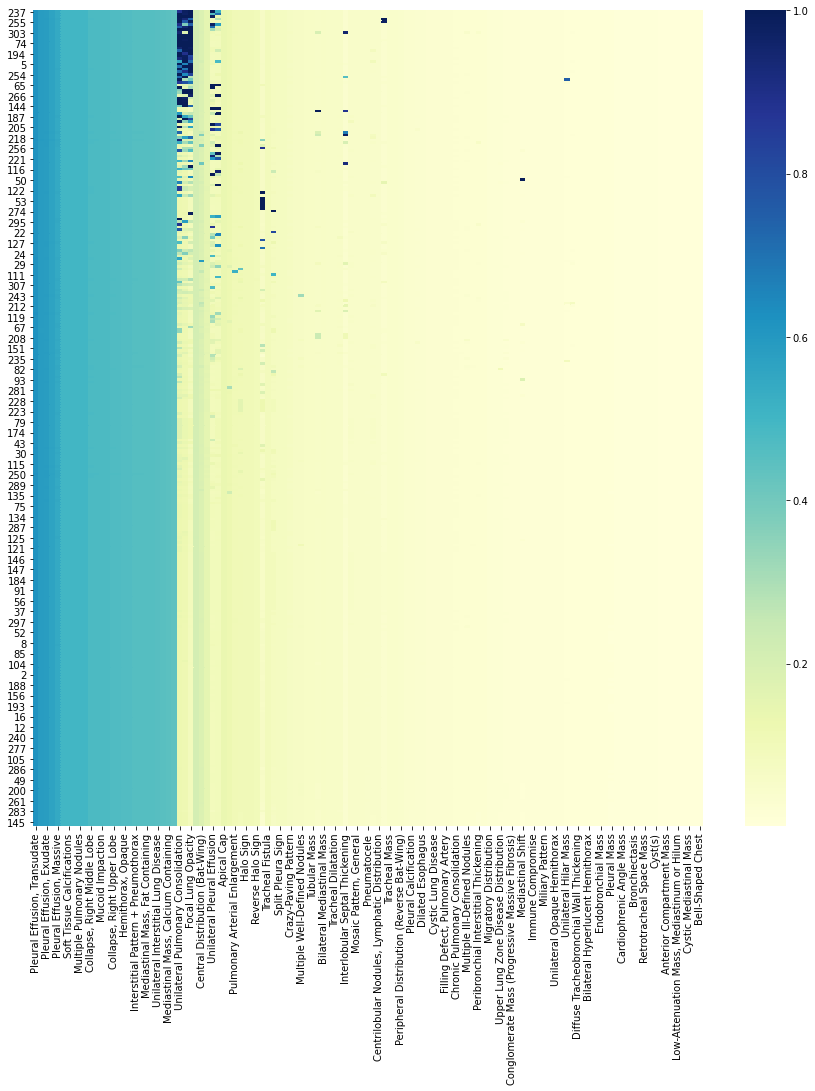

In [191]:
import seaborn as sns

dfw=pd.DataFrame(y_pred,columns=concepts)
#dfw['i']=
#dfw=dfw.set_index('i')
dfw=dfw.reindex(dfw.mean(axis=1).sort_values(ascending=False).index)
dfw=dfw[dfw.mean(axis=0).sort_values(ascending=False).index]
dfw = dfw.T[dfw.sum(axis=0)!=0].T
dfw = dfw[dfw.sum(axis=1)>0]
fig, ax = plt.subplots(figsize=(15,15)) 
ax=sns.heatmap(dfw,
            cmap='YlGnBu',
              annot=False)

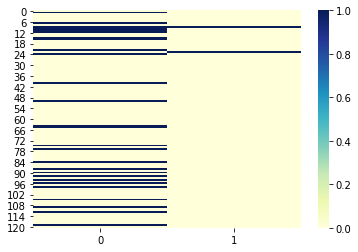

In [200]:
ax=sns.heatmap(np.array([y_pred[10]>.4,y_test[10]]).T,
            cmap='YlGnBu',
              annot=False)

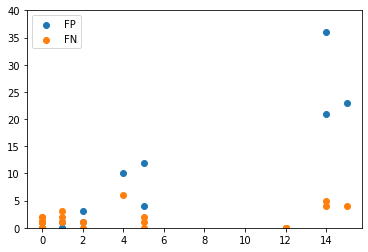

In [217]:
ATP = np.sum((y_test==1) * (y_pred >.5),axis=0)
AFP = np.sum((y_test==0) * (y_pred >.5),axis=0)
AFN = np.sum((y_test==1) * (y_pred <.5),axis=0)
plt.scatter(ATP,AFP,label='FP')
plt.scatter(ATP,AFN,label='FN')
plt.ylim((0,40))
plt.legend()

In [225]:
pd.DataFrame([a for a in Counter({c:p for c,p in zip(concepts,AFN)}).most_common() if a[1]>0])

,0,1
0,Unilateral Pleural Effusion,6
1,Acute Pulmonary Consolidation,5
2,Focal Lung Opacity,4
3,Unilateral Pulmonary Consolidation,4
4,Central Distribution (Bat-Wing),3
5,Diffuse Tracheobronchial Wall Thickening,2
6,Bilateral Pleural Effusion,2
7,Solitary Pulmonary Nodule,2
8,Retrocardiac Mass,2
9,Interlobular Septal Thickening,1


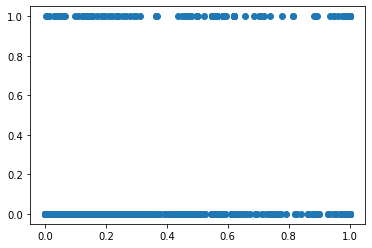

In [230]:
plt.scatter(y_pred,y_test)